# ARIA - Inteligência Artificial para Prevenção de Acidentes

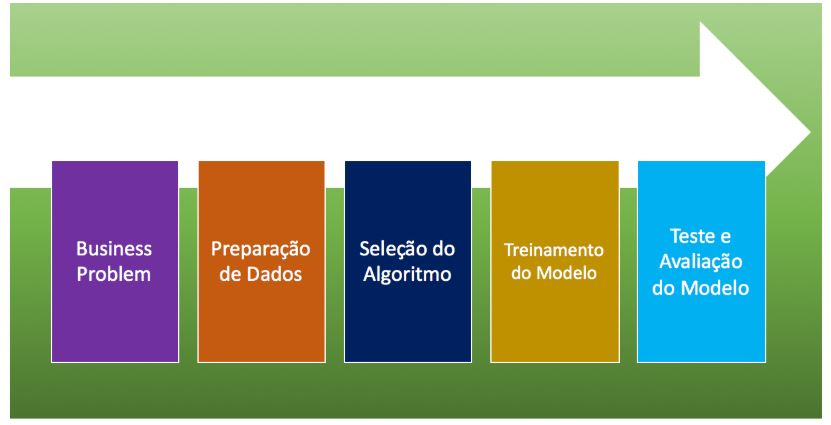

In [1]:
from IPython.display import Image
Image('workflow.JPG')

## Problema - O Motorista está em risco de sofrer acidente?
A análise de um conjunto de dados como hábitos do motorista, perfil de condução, região onde está trafegando, saúde mental, condições de descanso, entre outras, pode ajudar na prevenção de acidentes e na manutenção da vida.
## Problema de Negócio
**Objetivo** - Definir com 70% de precisão ou mais, o risco de acidente do motorista. Como não estamos lidando com dados reais, e nem todas as etapas de análise e treinamento do modelo foram realizadas, os resultados serão altamente distorcidos.


## Instalação e Importação das Bibliotecas
Para este exemplo, faremos uma análise simples dos dados utilizando o classificador Naive Bayes.

In [0]:
!pip install scikit-plot 
!pip install dfply
!pip install dtreeviz

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
%matplotlib inline
import pandas as pd
import sklearn
from joblib import dump
import prince
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from dfply import *
from dtreeviz.trees import *
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import Image
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

## Importando a Base de Dados

In [0]:
# Carregando o dataset
df = pd.read_csv('box_data.csv', sep = '|', encoding = 'latin-1') 

## Análise Exploratória dos dados

In [10]:
# Verificando o formato dos dados
df.shape

(2000, 11)

In [11]:
# Verificando as primeiras linhas do dataset
df.head(5)

,hipertenso,diabetico,km_rodado_dia,media_horas_sono,media_agua_diaria,cigarros_fumados,horas_descanso,ansiedade_detectada,latitude,longitude,acidente
0,0,1,28,8,3,57,21,0,-86.26540,-123.69433,1
1,1,1,140,0,0,25,19,1,36.42210,-101.64467,1
2,0,0,181,4,1,46,17,1,-14.66674,156.11742,0
3,1,0,239,16,0,57,24,1,-77.03761,67.51410,1
4,0,1,805,0,1,60,20,0,62.35705,4.99045,0


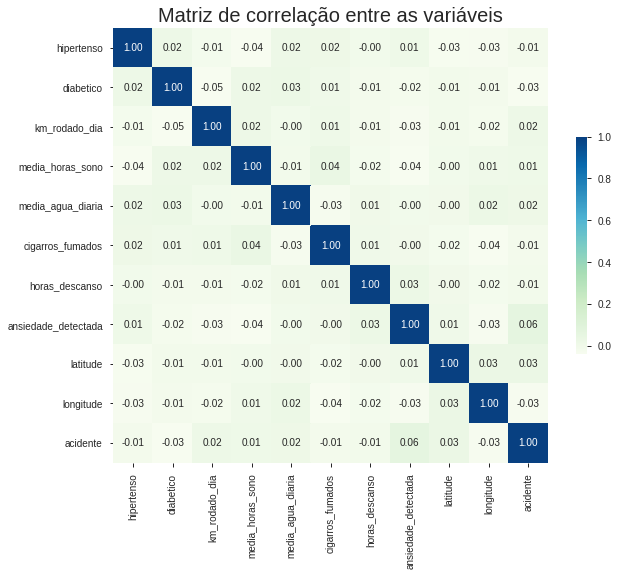

In [22]:
# Identificando a correlação entre as variáveis
# Correlação não implica causalidade
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True, annot=True,fmt='.2f', cmap ='GnBu', cbar_kws={"shrink": .5}, robust=True)
plt.title('Matriz de correlação entre as variáveis', fontsize=20)
plt.show()

In [23]:
# Visualizando a correlação em tabela
# Coeficiente de correlação: 
# +1  = forte correlação positiva
# 0   = não há correlação
# -1  = forte correlação negativa
df.corr()

,hipertenso,diabetico,km_rodado_dia,media_horas_sono,media_agua_diaria,cigarros_fumados,horas_descanso,ansiedade_detectada,latitude,longitude,acidente
hipertenso,1.000000,0.020260,-0.014534,-0.035118,0.020852,0.017659,-0.003194,0.013990,-0.034192,-0.026741,-0.013269
diabetico,0.020260,1.000000,-0.049289,0.018508,0.026438,0.009647,-0.010126,-0.021983,-0.009224,-0.013806,-0.034467
km_rodado_dia,-0.014534,-0.049289,1.000000,0.018498,-0.003855,0.011133,-0.010486,-0.028426,-0.007649,-0.018829,0.022017
media_horas_sono,-0.035118,0.018508,0.018498,1.000000,-0.008681,0.035118,-0.016906,-0.038461,-0.004368,0.007451,0.010541
media_agua_diaria,0.020852,0.026438,-0.003855,-0.008681,1.000000,-0.025776,0.005982,-0.004456,-0.000796,0.022551,0.015549
cigarros_fumados,0.017659,0.009647,0.011133,0.035118,-0.025776,1.000000,0.009478,-0.001191,-0.015328,-0.036633,-0.011430
horas_descanso,-0.003194,-0.010126,-0.010486,-0.016906,0.005982,0.009478,1.000000,0.025621,-0.000028,-0.015641,-0.006701
ansiedade_detectada,0.013990,-0.021983,-0.028426,-0.038461,-0.004456,-0.001191,0.025621,1.000000,0.008290,-0.027376,0.062994
latitude,-0.034192,-0.009224,-0.007649,-0.004368,-0.000796,-0.015328,-0.000028,0.008290,1.000000,0.027569,0.027896
longitude,-0.026741,-0.013806,-0.018829,0.007451,0.022551,-0.036633,-0.015641,-0.027376,0.027569,1.000000,-0.028806


## Tratamento da Base de Dados

In [36]:
# Verificando se existem valores nulos
df.isnull().values.any()

False

## Divisão da base de em atributos previsores e atributo classe

In [0]:
# Atributos Previsores
previsores = df.iloc[:, 0:-1]
# Atributos Classe
classe = df.iloc[:, -1:]

##Treinamento da Base de Dados
Uma das boas práticas no desenvolvimento de modelos de Machine Learning é separar a base em um conjunto de treino para treinar o modelo e outro de teste para validar os resultados do modelo. Essa separação é crucial a fim de identificar se o modelo não está “decorando” os resultados ao invés de aprender, o famoso overfitting.

Sobreajuste (overfitting) ocorre quando o modelo gerado decora a base e quando confrontado com novos dados obtem baixo desempenho.
Subajuste (underfitting), quando não consegue identificar nenhum padrão.
Separa-se em 4 subconjuntos, "previsores_treinamento" com as variáveis de input para treino do modelo e "classe_treinamento" com os resultados de predição para treino, ambos serão utilizados mais tarde no método fit do modelo, "previsores_teste" com as variáveis de input para teste e "classe_teste" com os resultados da predição para testes.

Serão separado 70% dos dados para treino e 30% para teste.


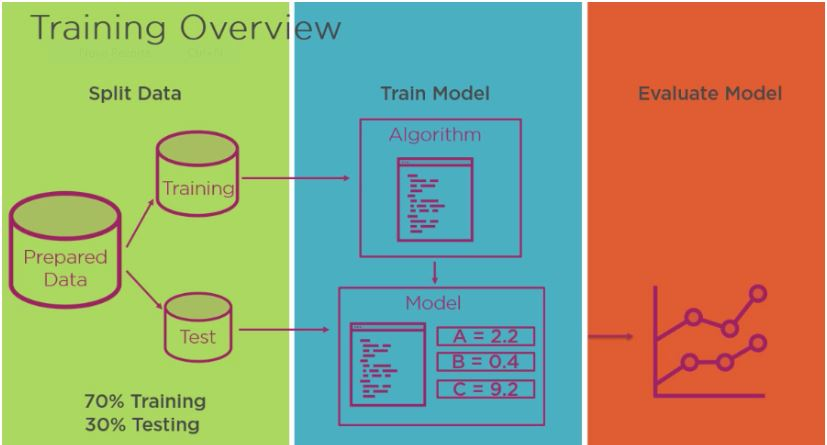

In [38]:
from IPython.display import Image
Image('treinamento overview.JPG')

In [39]:
previsores_treinamento, previsores_teste, classe_treinamento, classe_teste = train_test_split(previsores, classe, test_size=0.30, random_state=101)
# Imprimindo os resultados
print("{0:0.2f}% nos dados de treino".format((len(previsores_treinamento)/len(df.index)) * 100))
print("{0:0.2f}% nos dados de teste".format((len(previsores_teste)/len(df.index)) * 100))

70.00% nos dados de treino
30.00% nos dados de teste


## Função Auxiliar para Execução dos Modelos de Classificação

In [0]:
def runModel(model, previsores_treinamento, classe_treinamento, previsores_teste, classe_teste, confusion_matrix=False, normalizeCM=False, roc=True, plot_calibration=False, random_state=42, title="", pos_label=1):
    """Função auxiliar para execução de modelos de classificação.
    
    Parâmetros:
    
    - model: modelo de classificação a ser executado
    - previsores_treinamento: base de treinamento das variáveis preditoras
    - classe_treinamento: base de treinamento da classe
    - previsores_teste: base de teste das variáveis preditoras
    - classe_teste: base de teste da classe
    - confusion_matrix (default: True): exibir a matriz de confusão da classificação
    - normalizeCM (default: False): define se a matriz de confusão será normalizada
    - roc (default: True): define se será exibida a curva ROC para o classificador
    - plot_calibration (default: True): define se será exibida a curva de calibração para o classificador
    - title: define o título a ser exibido nos gráficos
    - pos_label: indica qual o valor de classe_treinamento e classe_teste que representa a classe positiva. O valor default é 1. 

    """
    clf = model
    name = title
    clf.fit(previsores_treinamento, classe_treinamento)
    y_pred = clf.predict(previsores_teste)
        
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(previsores_teste)
    else:  # use decision function
        prob_pos = clf.decision_function(previsores_teste)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    if confusion_matrix:
       skplt.metrics.plot_confusion_matrix(classe_teste, y_pred, normalize=normalizeCM, title=name)
    if roc:
       skplt.metrics.plot_roc(classe_teste, prob_pos, plot_micro=False, plot_macro=False, classes_to_plot=[1], title=name,figsize=(10,10))
     
            
    prob_pos = prob_pos[:,1]
    clf_score = brier_score_loss(classe_teste, prob_pos, pos_label=pos_label)
    print("%s:" % name)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(classe_teste, y_pred))
    print("\tRecall: %1.3f" % recall_score(classe_teste, y_pred))
    print("\tF1: %1.3f\n" % f1_score(classe_teste, y_pred))
        
    if plot_calibration:
      
      fraction_of_positives, mean_predicted_value = \
                calibration_curve(classe_teste, prob_pos, n_bins=10)
      plt.rcParams.update({'font.size': 22})
      plt.rc('legend',**{'fontsize':22})
      fig = plt.figure(3, figsize=(10, 10))
      ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
      ax2 = plt.subplot2grid((3, 1), (2, 0))
      ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado",)
      ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                     label="%s (%1.3f)" % (name, clf_score))

      ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                     histtype="step", lw=2)

      ax1.set_ylabel("Fração de positivos")
      ax1.set_ylim([-0.05, 1.05])
      ax1.legend(loc="lower right")
      ax1.set_title('Gráfico de Calibração  (reliability curve)')
      
      ax2.set_xlabel("Valor médio predito")
      ax2.set_ylabel("Quantidade")
      ax2.legend(loc="upper center", ncol=2)
      
      for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(22)
        
      for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(22)
      
      plt.tight_layout()
      plt.show()

## Treinamento do Modelo utilizando o Naive Bayes para classificação dos dados

In [46]:
# Construindo e treinando o modelo
# Modelo_V1 utilizando o classificador Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_classifier = GaussianNB()
nb_classifier.fit(previsores_treinamento, classe_treinamento.values.ravel())
dump(nb_classifier, "naive_bayes.joblib")

GaussianNB(priors=None, var_smoothing=1e-09)

['naive_bayes.joblib']

In [47]:
# Verificando a exatidão do modelo nos dados de teste
from sklearn import metrics
nb_predict_test = nb_classifier.predict(previsores_teste)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(classe_teste, nb_predict_test)))
print()

Exatidão (Accuracy): 0.4983



## Analisando os Resultados

In [48]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(classe_teste, nb_predict_test, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(classe_teste, nb_predict_test, labels = [1, 0]))

Confusion Matrix
[[180 132]
 [169 119]]

Classification Report
              precision    recall  f1-score   support

           1       0.52      0.58      0.54       312
           0       0.47      0.41      0.44       288

    accuracy                           0.50       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.50      0.50      0.50       600



In [50]:
previsoes = nb_classifier.predict_proba(previsores_teste)
previsoes = pd.DataFrame(previsoes)
classe_teste = np.array(classe_teste)
classe_teste = classe_teste.reshape(-1,1)
classe_teste.shape
classe_teste = pd.DataFrame(classe_teste)
previsoes_concat =  pd.concat([previsoes,classe_teste], axis=1)
previsoes_concat.columns=['Com Risco','Sem Risco','Classe']
previsoes_concat

(600, 1)

,Com Risco,Sem Risco,Classe
0,0.487921,0.512079,0
1,0.472170,0.527830,1
2,0.496620,0.503380,1
3,0.585789,0.414211,1
4,0.491468,0.508532,0
...,...,...,...
595,0.568550,0.431450,1
596,0.514249,0.485751,1
597,0.460201,0.539799,0
598,0.484544,0.515456,0


## Análise da Curva ROC

Naive Bayes:
	Brier: 0.253
	Precision: 0.516
	Recall: 0.577
	F1: 0.545



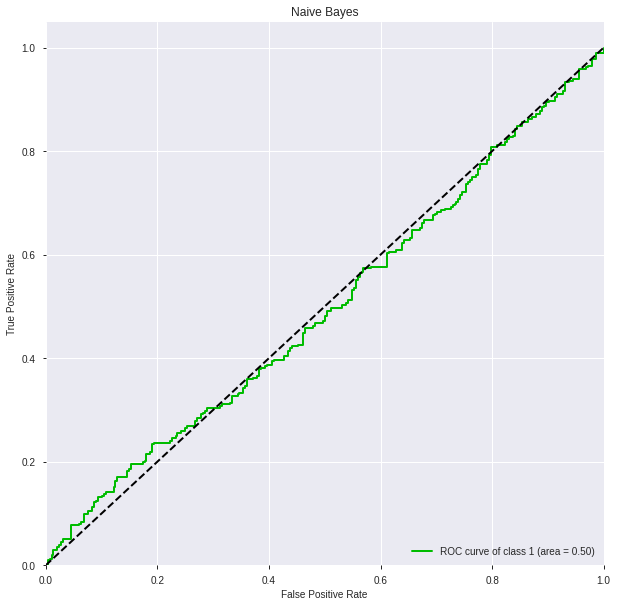

In [51]:
nb_classifier = GaussianNB()
runModel(nb_classifier, previsores_treinamento, classe_treinamento, previsores_teste, classe_teste, title="Naive Bayes")